Welcome to chemscreen, a program for screening namy differentials on kinetic data to find the best fit.
Please mind that the initial conditions should be tuned so the rates don't exceed 1.

In [2]:
# Needed imports
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random
import progressbar

In [3]:
# Some general variables needed for our specific differentials
P = 50
KH= 1282
CH2 = P/KH
R= 8.314
timespan = [0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246]
time = timespan[-1]

In [4]:
def preprocess_matrix(matrix,ks,reactions,concs,to_run):
    "Changes the string based matrices to a handleable format for the differential"
    reactions = dict(reactions) #We make containers that store the right things in the right place
    matrix = dict(matrix)
    for key,dic in matrix.items():
        matrix[key] = dict(dic)
    ks = list(ks)
    concs = list(concs)
    
    for val in matrix.values(): # Take out any reaction options that are not in to_run
        keylist = []
        for key in val.keys():            
            if key not in to_run.keys():
                keylist.append(key)                
        for pos in keylist:
            del val[pos]
            
    
    keylist = []
    for key in reactions.keys(): # If an entire reaction is not applicable also take that out           
        if key not in to_run.keys():
            keylist.append(key) 
    for pos in keylist:
        del reactions[pos]
        ks[pos-1] = 0

    
    keylist = [] # This is for deleting concentrations or parts of the matrix if the are not applicable
    i=0
    poslist = []
    for key,dic in matrix.items():
        if dic == {}:
            keylist.append(key)
            poslist.append(i)
        i+=1
        
    for key in keylist: 
        del matrix[key]
    poslist.reverse()
    for pos in poslist:
        del concs[pos]
        
    return matrix, ks, reactions, concs

In [5]:
def preprocess_reactions(reactions,to_run):
    "Changes the reactions to a more easy to handle format for the differential"
    for reaction in reactions.keys():
        reactions[reaction] = reactions[reaction][to_run[reaction]-1]
    return reactions

In [6]:
def diff(x, concs, ks,reacts,matrix):
    "Executes the differential based on the processed inputs"
    dt_list = []
    for val in (list(matrix.values())): #For all things in the matrix
        tot = 0
        for key,value in val.items(): 
            react = reacts[key] #Get the associated reaction
            tot += value*eval(react) #Add it to the total version
        dt_list.append(tot) #append it to a list so the total change can be returned
    for i in range(len(concs)-len(dt_list)):
        dt_list.append(0) #if the length of the initial condition and output are not the same add a 0
    return dt_list

In [7]:
class ODE_systems:
    "Class to store and keep track of ODE systems"
    def __init__(self, reactions, matrix,ks,to_run = None):
        self.reactions = reactions
        self.matrix = matrix
        self.ks = [0.01 for i in range(ks)]
        self.concs = [1 for i in range(len(matrix))]
        if to_run != None:
            self.to_run = to_run
        else:
            self.to_run = None
        
    
    def get_matrices(self):
        "Makes the processed differentials from the user inputs"
        systems_list = []
        if self.to_run != None:
            for run in self.to_run:
                new_matrix, new_ks, new_reactions, new_concs = preprocess_matrix(self.matrix,self.ks,self.reactions,self.concs,run)
                new_reactions = preprocess_reactions(new_reactions,run)
                systems_list.append([dict(new_matrix), list(new_ks), dict(new_reactions), list(new_concs), len(new_ks)])
        else:
            systems_list.append([self.matrix, self.ks, self.reactions, self.concs])
        return systems_list
                                                                                 

In [8]:
def get_A(ktrue, E_act, ref_temp):
    "To derive arrhenius constant from the rate constant at the first input temperature and the activation energy"
    R = 8.314
    E_act = np.array(E_act)
    T= ref_temp
    A = ktrue/(np.exp(-E_act/(ref_temp*R))) #Arrhenius rate law
    return A

In [9]:
def get_noise(t,var,stat):
    "Function to add noise to the data"
    length = len(t)
    static_noise = np.random.normal(0,stat,length)
    variable_noise = np.random.normal(0,var,length)
    return static_noise, variable_noise

In [10]:
def make_data(system,timespan ,Ts,inits,ks,kin_params = None,var_noise = 0, stat_noise = 0):
    "Makes a dataset out of the specified kinetic parameters, times, temperatures, and initial conditions, with noise if specified"
    time = timespan[-1]
    
    if kin_params:
        pre_consts = get_A(ks,kin_params,Ts[0])
        
    
    sol_list = []
    noisy_data_lists = []
    for init in inits: #For all initial conditions
        for T in Ts: #For all temperatures
            noisy_data = []
            if kin_params != None:
                rate_consts = pre_consts*np.exp(-np.array(kin_params)/(R*T))
            else:
                rate_consts = ks
            sol = integrate.solve_ivp(system, [0,time], init, t_eval = timespan, args=[rate_consts]) #get the initial value problem data
            indexes = []
            
            for i in range(len(sol.y)):
                if sol.y[i][-1] == sol.y[i][0]: #if a quantitiy doesn't change delete it from the data
                    indexes.append(i)
            indexes.reverse()
            sol.y = list(sol.y)
            if indexes != []:
                for index in indexes:
                    del sol.y[index]
                sol.y = np.array(sol.y)
            for line in sol.y: #and for all species
                static_noise,variable_noise = get_noise(timespan,var_noise,stat_noise) #add the noise
                noisy_data.append(line + static_noise + np.multiply(line,variable_noise))
            data_dict = {"t" : timespan, "y": noisy_data, "T": T, "init" : init}
            noisy_data_lists.append(data_dict)
            

        
    noisy_data_lists = np.array(noisy_data_lists)
    return noisy_data_lists

In [11]:
def change_coord(data,timespan):
    "Changes the concentration vs time values to the rate vs time values for more precise fitting"
    rate_lists = []
    for line in range(len(data)): #For all datasets
        rate_list = []
        for i in range(len(data[line])-1): # For all lines in that data
            rate_list.append((data[line][i+1]-data[line][i])/(timespan[i+1]-timespan[i])) #Get the rate profile  
        rate_lists.append(rate_list)
    return rate_lists

In [12]:
def get_r2(real,simul,num_lines,timespan):
    "Calculates the R-squared of compared datasets"
    tot_score = 0
    real_rate, simul_rate = change_coord(real, timespan), change_coord(simul, timespan)
    for i in range(num_lines):
        tot_score += r2_score(real[i],simul[i]) +r2_score(real_rate[i],simul_rate[i])
    return tot_score

In [13]:
def kin_params_guesses(constants, Ts):
    "Plots and returns the guessed activation energy and Arrhenius constant based on rate constants at certain temperatures"
    Eact_list = []
    A_list = []
    for i in range(len(constants[0])): #For all constants
        log_list = []
        for constant_list in constants:
            log_list.append(np.log(constant_list[i])) #Change the axes to get a linear relationship
        reciprocal_list = 1/np.array(Ts)
        lin_model = np.polyfit(reciprocal_list,log_list,1) #Get linear fit
        slope = lin_model[0] #And from the slope and intercept
        intercept = lin_model[1]
        Eact_list.append(slope*8.314) #Get the kinetic constants
        A_list.append(np.exp(intercept))
        plt.figure(100)
        plt.title('arrhenius plot')
        plt.scatter(reciprocal_list,log_list, label = f'k{i}')
        plt.plot(reciprocal_list, np.array(reciprocal_list)*slope+intercept, label = 'fit')
        plt.legend()
    return Eact_list, A_list

In [14]:
def fit_sim(system,data, iterations):
    "Main function for optimizing to an optimal fit, does this only at a single temperature"
    matrix,reacts,num_ks,init = system[0],system[2],len(system[1]), system[3] #Get all needed constants
    if len(data) <= 1:
        init_list = [data[0]['init']]
        T = data[0]['T']
        values_list = [data[0]['y']]
        timespan_list = [data[0]['t']]
        time_list = [data[0]['t'][-1]]
        max_score = len(matrix)*2
    else:
        T = data[0]['T']
        init_list = []
        values_list = []
        timespan_list = []
        time_list = []
        max_score = 0
        for entry in data:
            init_list.append(entry['init'])
            values_list.append(entry['y'])
            timespan_list.append(entry['t'])
            time_list.append(entry['t'][-1])
            max_score += 2*len(matrix)
    
    bar = progressbar.ProgressBar(max_value=iterations)
    progress = []        

    def residual(paras):
        "compute the residual between actual data and fitted data"
        param_list = []
        for param in paras:
            param_list.append(paras[param].value)
            

        score = 0
        for i in range(len(data)):
            sol = integrate.solve_ivp(diff, [0,time_list[i]], init_list[i], t_eval = timespan_list[i], args=[param_list,reacts,matrix]) #Get a run with the guessed parameters
            score += get_r2(values_list[i], sol.y, len(data[0]['y']), timespan_list[i]) #Get the associated error
            
        if len(progress) < iterations:
            progress.append(0)
            bar.update(len(progress))

        to_return = [max_score-score for i in range(len(paras))]
        return to_return

    

    params = Parameters() #make the parameters to vary
    for i in range(num_ks):
        params.add(f'k{i}',value=0.01, min=1e-10, max=1)

    #Minimize the difference between the data and the simulated fit
    results = minimize(residual, params, method='leastsq', max_nfev = iterations) #Get the final results
    
    #And for those parameters get the run details and plots
    result_list = []
    for param in results.params:
        result_list.append(results.params[param].value)

    
    final_res = []
    
    for i in range(len(results.params)):
        final_res.append(results.params[f'k{i}'].value)

    
    for j in range(len(data)):
        data_fitted = integrate.solve_ivp(diff, [0,time_list[j]], init_list[j], t_eval = timespan_list[j], args=[result_list,reacts,matrix])
        plt.figure()
        if len(values_list[j])> len(matrix.items()):
            for i in range(len(matrix.items())):
                plt.plot(data_fitted.t,data_fitted.y[i], label =list(matrix.keys())[i][1:-2])
                plt.scatter(timespan_list[j], values_list[j][i], label =list(matrix.keys())[i][1:-2])
        else:
            for i in range(len(values_list[j])):
                plt.scatter(timespan_list[j], values_list[j][i], label =list(matrix.keys())[i][1:-2])
                plt.plot(data_fitted.t,data_fitted.y[i], label =list(matrix.keys())[i][1:-2])
        plt.title(f'single temperature fit plot at temperature: {T} K')
        plt.ylabel('concentration')
        plt.xlabel('time')
        plt.legend()
    sim = max_score-residual(results.params)[0]
    print(f'score for temperature fit of {T} is: {sim} out of {max_score} \n \n fit results:')
    # display fitted statistics
    report_fit(results)
    
    final_res = []
    
    for i in range(len(results.params)):
        final_res.append(results.params[f'k{i}'].value)
    
    return final_res, T

In [15]:
def get_lines(diff, param_list, reacts, matrix,T, data):
    "Helper function for executing the differentials for the activation energy and Arrhenius constant guesses"
    ks_list = []
    half = int(len(param_list)/2)
    for i in range(half): #The list has the acivation energies and Arrhenius pre-factors so we split it
        ks_list.append(param_list[i]*np.exp(-param_list[half+i]/(R*T))) #Get the rate constants

    init= data['init'] #Get all other constants
    T = data['T']
    timespan = data['t']
    time= timespan[-1]
    lines = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan, args=[ks_list,reacts,matrix]) #Get the rusn

    return lines

In [16]:
def fit_sim_full(system,data, temps, Eacts, As,iterations):
    "Main function for optimizing to an optimal fit, does this at all temperature by guessing activation energies and Arrhenius constants"
    matrix,reacts,num_ks,init = system[0],system[2],len(system[1]), system[3] #Again get all constants
    R = 8.314
    max_score = len(data)*len(data[0]['y'])*2
    pre_consts = []
    E_acts = []
    As_names = []
    Eacts_names = []
    for i in range(num_ks):
        As_names.append(f'A{i+1}')
        Eacts_names.append(f'E{i+1}')
    bar = progressbar.ProgressBar(max_value=iterations)
    progress = []  
    
    def residual(paras):
        "compute the residual between actual data and fitted data"
        param_list = []
        
        for param in paras:
            param_list.append(paras[param].value)
        
        
        half = int(len(param_list)/2)
        for i in range(half):
            val = param_list[i]*np.exp(-param_list[half+i]/(R*temps[-1]))
            if val >1: #if a rate is above 1 the differential gets executed slow, so we return the worst score for that
                to_return = [max_score for i in range(len(paras))]
                return to_return
        lines_list = []
        for i in range(len(data)): #from here it is similar to the base fit comparison
            T_current = data[i]['T']
            lines = get_lines(diff,param_list,reacts,matrix,T_current,data[i])
            lines_list.append(lines)


        score = 0
        num = 0
        for run in data:
            score += get_r2(run['y'], lines_list[num].y,len(run['y']), run['t'])
            num += 1
            
        if len(progress) < iterations:
            progress.append(0)
            bar.update(len(progress))
        
        to_return = [max_score-score for i in range(len(paras))]
        return to_return

    params = Parameters() #Now we don't feed rate constants but activation energies and Arrhenius pre-factors
    for i in range(len(As)):
        params.add(As_names[i],value=As[i], min=1e-5, max=1e5)
    for i in range(len(Eacts)):
        params.add(Eacts_names[i],value=-Eacts[i], min=1000, max=100000)    

    #Again get the final result and get the details and plots
    results = minimize(residual, params, method='leastsq', max_nfev = iterations)
    
    result_list = []
    for param in results.params:
        result_list.append(results.params[param].value)

    bar.update(iterations)
    
    for i in range(len(data)):
        if len(data[0]['y']) > len(matrix.items()):
            T_current = data[i]['T']
            mock_run = get_lines(diff,result_list,reacts,matrix,T_current,data[i])
            plt.figure()
            for j in range(len(matrix.items())):
                plt.scatter(data[i]['t'],data[i]['y'][j], label =list(matrix.keys())[j][1:-2])#, color= colors[j])
                plt.plot(mock_run.t, mock_run.y[j], label =list(matrix.keys())[j][1:-2])#, color= colors[j])
            plt.legend()
            plt.title(f'Simultaneous fitting plot for temperature: {T_current} K')
            plt.ylabel('Concentration')
            plt.xlabel('Time')
            plt.savefig(f"C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/multi_fit{i}.svg",dpi=300)
        else:
            T_current = data[i]['T']
            mock_run = get_lines(diff,result_list,reacts,matrix,T_current,data[i])
            plt.figure()
            for j in range(len(data[0]['y'])):
                plt.scatter(data[i]['t'],data[i]['y'][j], label =list(matrix.keys())[j][1:-2])#, color= colors[j])
                plt.plot(mock_run.t, mock_run.y[j], label =list(matrix.keys())[j][1:-2])#, color= colors[j])
            plt.legend()
            plt.title(f'Simultaneous fitting plot for temperature: {T_current} K')
            plt.ylabel('Concentration')
            plt.xlabel('Time')
            plt.savefig(f"C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/multi_fit{i}.svg",dpi=300)
            
    sim = max_score-residual(results.params)[0]
    print(f'full fit score is: {sim} out of {max_score}\n \n fit results:')

    report_fit(results)
    
    return results.params

In [34]:
class fit_data():
    "Class to execute and store a fitting procedure"
    def __init__(self, data, systems):
        self.data = data
        self.systems = systems.get_matrices()
        
    def fit_one(self,entry_num,system_num, iterations = 1000):
        "for fitting a single run with a single system"
        data = [self.data[entry_num]]
        system = self.systems[system_num]
        fit_sim(system,data,iterations)
        
    def fit_many_entries(self,entries,system_num, iterations = 1000):
        "for multiple runs with a single system"
        for entry in entries:
            data = [self.data[entry]]
            system = self.systems[system_num]
            fit_sim(system,data,iterations)
    
    def fit_many_systems(self,entry_num,systems, iterations = 1000):
        "for fitting one run with multiple systems"
        for system in systems:
            data = [self.data[entry_num]]
            system = self.systems[system]
            fit_sim(system,data,iterations)
    
    def fit_many(self,entries,systems, iterations = 1000):
        "for fitting multiple runs with multiple systems"
        for entry in entries:
            for system in systems:            
                data = [self.data[entry]]
                system = self.systems[system]
                fit_sim(system,data,iterations)
                
    def fit_full(self,system_num, iterations = 1000, iterations_full = 1000):
        "for fitting all data with a single system and for fitting across different temperatures"
        system = self.systems[system_num]
        unique_temps = []
        data_list = []
        params_list = []
        T_list = []
        for entry in self.data:
            unique_temps.append(entry['T'])
        unique_temps = set(unique_temps)
        unique_temps = list(unique_temps)
        unique_temps.sort()
        for temp in unique_temps:
            hits = []
            for entry in self.data:
                if entry['T'] == temp:
                    hits.append(entry)
            data_list.append(hits)
        for pair in data_list:
            params, T = fit_sim(system,pair,iterations)
            params_list.append(params)
            T_list.append(T)
        Eacts, As = kin_params_guesses(params_list,T_list)
        fit_sim_full(system,self.data,T_list,Eacts,As, iterations_full)
        
            

Now follow the three differentials we use, if you want to use this it is very similar to a basic scipy differential, but mind how the rate constants are imported, and that the amount of concentrations and returned differences needs to have the same length as the initial condition input. This is because the inital conditions that make the data that you provide don't change based on the differential you fit it to

In [35]:
def diff_1(x, init, rate_const):
    "Simpelest differential system"
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead = init
    k1= rate_const[0]
    dEdt = -k1*CE
    dA1dt = k1*CE
    dA2dt = k1*CE
    return dEdt, dA1dt, dA2dt,0,0,0,0

In [36]:
def diff_2(x, init, rate_const):
    "A little more complex, this has catalyst dynamics"
    CE, CA1, CA2,Ccatdead, Cprecat, CtE, Ccat,CH2= init
    k1, k2 = rate_const[0], rate_const[1]
    dEdt = -k1*CE*Cprecat
    dA1dt = k1*CE*Cprecat
    dA2dt = k1*CE*Cprecat
    dprecatdt = -k2*Cprecat
    dcatdeaddt = k2*Cprecat
    return dEdt, dA1dt, dA2dt, dcatdeaddt, dprecatdt, 0,0,0

In [37]:
def diff_6(x, init, rate_const):
    "The full system for catalytic ester hydrogenation, also see how constants can still be used in CH2"
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, CH2 = init
    k1, k2, k3, k4, k5, k6= rate_const[0],rate_const[1],rate_const[2],rate_const[3],rate_const[4],rate_const[5]
    dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
    dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
    dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
    dcatdeaddt = k6*Cprecat
    dCH2dt = 0
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, 0

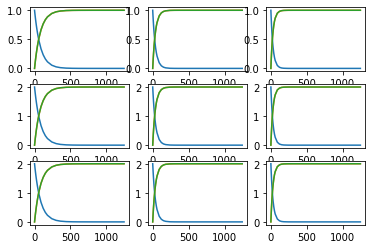

In [38]:
# This cell is for making simple data, for the full explanation see the 2 cells below
# You can choose which data to fit to by running either this or the two cells below
data = make_data(diff_1,timespan ,[300,400,450],[[1,0,0,0,1,0,0],[2,0,0,0,2,0,0],[2,0,0,0,1,0,0]],[0.01209668296564242],var_noise = 0, stat_noise = 0,kin_params = [7573])

rows = 3
cols = 3
for i in range(len(data)):
    plt.subplot(rows, cols, i+1)
    plt.plot(data[0]['t'],data[i]['y'][0])
    plt.plot(data[0]['t'],data[i]['y'][1])
    plt.plot(data[0]['t'],data[i]['y'][2])


In [39]:
#these are the variable needed to make a chemical dataset
#mind that the concentrations that are put in are best put in so that the rates are below 1, further below is better
temp_1 = 300
temp_2 = 350
temp_3 = 400
sub_1 = 1
sub_2 = 2
sub_3 = 2
cat_1 = 1
cat_2 = 2
cat_3 = 1
k1,k2,k3,k4,k5,k6 = 0.012,0.015,0.004,0.04,0.03,0.012
E1,E2,E3,E4,E5,E6 = 17507,14058,16473,12132,12396,24312
var_noise = 0
stat_noise = 0

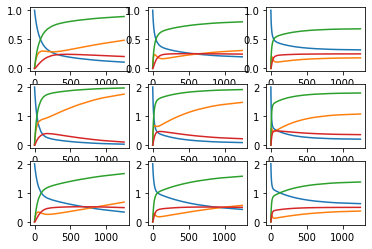

In [40]:
#now that we have a system lets make data out of it
#the make data function looks like this make_data (system,timespan ,Ts,inits,ks,kin_params = None,var_noise = 0, stat_noise = 0)
#system is the differential system the data is made for, timespan is the time measured over, Ts is all temperatures you want simulated
#inits is all the inits you want simulated, ks is the value of the rate constants, var_noise and stat_noise allow you to add noise to data
# kin_params is for when simulations are done at different temperatures, because the rate constants change of course. the structure is [Eact1,Eact2,etc...]
data = make_data(diff_6,timespan ,[temp_1,temp_2,temp_3],[[sub_1,0,0,0,cat_1,0,0,0.04],[sub_2,0,0,0,cat_2,0,0,0.04],[sub_3,0,0,0,cat_3,0,0,0.04]],[k1,k2,k3,k4,k5,k6],
                     var_noise = var_noise, stat_noise = stat_noise,kin_params = [E1,E2,E3,E4,E5,E6])
#plot to visualize how the generated data looks
rows = 3
cols = 3
for i in range(len(data)):
    plt.subplot(rows, cols, i+1)
    plt.plot(data[0]['t'],data[i]['y'][0])
    plt.plot(data[0]['t'],data[i]['y'][1])
    plt.plot(data[0]['t'],data[i]['y'][2])
    plt.plot(data[0]['t'],data[i]['y'][3])

In [41]:
#this cell is to show how you make custom data, if there is real data it can be implemeted in this format
# t = [0,1,2,3,4,5]
# y = [np.array([1,0.7,0.55,0.45,0.35,0.3]),
#      np.array([0,0.4,0.55,0.65,0.75,0.8])]#it has the concentration steps at each time, (can be list of lists or list of arrays)
# y = [[1,0.7,0.55,0.45,0.35,0.3],
#     [0,0.4,0.55,0.65,0.75,0.8]] #data as list of lists
# T = 300 #temperature measured at
# init = [1, 0, 0, 0, 1, 0, 0] #initial conditions for the measurement

# # runs can be done in parallel, here we'll do 2
# t2 = [0,1,2,3,4,5]
# y2 = [np.array([2,1.2,0.95,0.85,0.75,0.65]),
#      np.array([0,1,1.2,1.4,1.5,1.6])]
# T2 = 400
# init2 = [2, 0, 0, 0, 1, 0, 0]

# data = [{'t':t, 'y':y, 'T':T, 'init':init},{'t':t2, 'y':y2, 'T':T2, 'init':init2}] #this is how to combine all the data in one dictionary

In [42]:
# simple example of running systems of ODE's

ks = 1 #define the number of rate constants

reactions = {1:"ks[0]*concs[0]"} #define the reactions that can happen in a dictionary, write them down as strings
matrix = {"dEdt": {1:-1},"dA1dt": {1:1},"dA2dt": {1:1}}#define which reactions apply to which species and with which coefficient. 1 for production -1 for consumption, 2,3,-4 etc for multiple per reaction

#if more reactions apply it would look like {"dEdt": {1:-1, 2:1}}
#for structuring of more complex system look at test_6 at the bottom

In [43]:
#make an ODE system out of it
test = ODE_systems(reactions,matrix,ks)

  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 300 is: -56.98831317936853 out of 18 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 1
    # variables        = 1
    chi-square         = 5623.24711
    reduced chi-square = 5623.24711
    Akaike info crit   = 10.6346646
    Bayesian info crit = 8.63466455
[[Variables]]
    k0:  0.00100908 +/- 1340.84423 (132877257.24%) (init = 0.01)


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 350 is: -92.53835125283662 out of 18 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 1
    # variables        = 1
    chi-square         = 12218.7271
    reduced chi-square = 12218.7271
    Akaike info crit   = 11.4107251
    Bayesian info crit = 9.41072506
[[Variables]]
    k0:  6.6623e-04 +/- 153.373308 (23021051.06%) (init = 0.01)


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 400 is: -137.47062473593758 out of 18 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 1
    # variables        = 1
    chi-square         = 24171.1152
    reduced chi-square = 24171.1152
    Akaike info crit   = 12.0929136
    Bayesian info crit = 10.0929136
[[Variables]]
    k0:  4.2627e-04 +/- 5.92805106 (1390695.21%) (init = 0.01)


  1% (18 of 1000) |                      | Elapsed Time: 0:00:09 ETA:   1:43:54

full fit score is: -295.21007772349014 out of 126
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 2
    # variables        = 2
    chi-square         = 354835.859
    reduced chi-square = 354835.859
    Akaike info crit   = 28.1725268
    Bayesian info crit = 25.5588212
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A1:  5.7793e-04 (init = 3.381849e-05)
    E1:  1000.03843 (init = 1000)


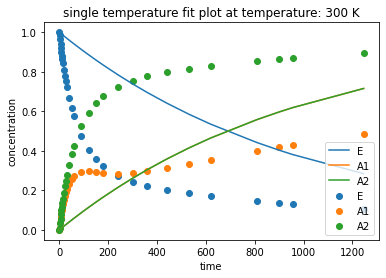

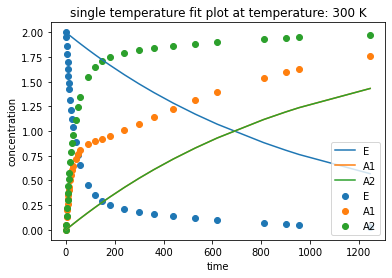

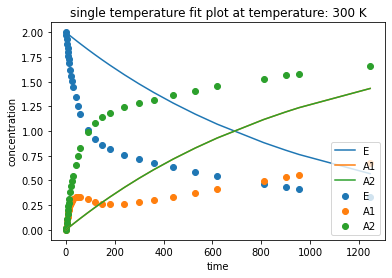

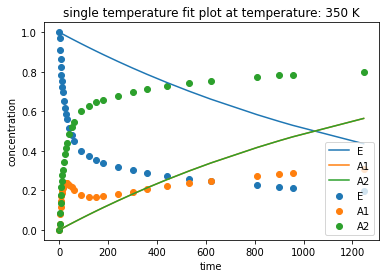

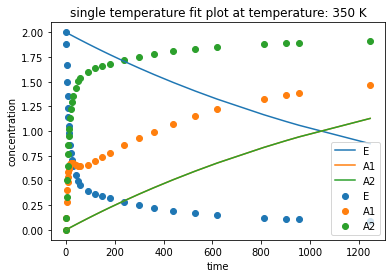

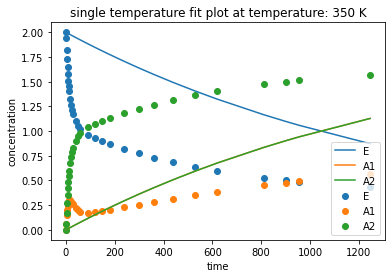

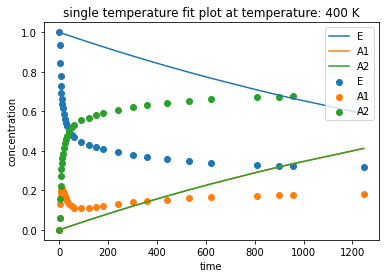

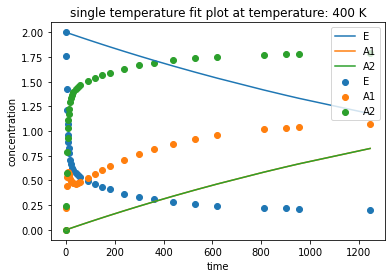

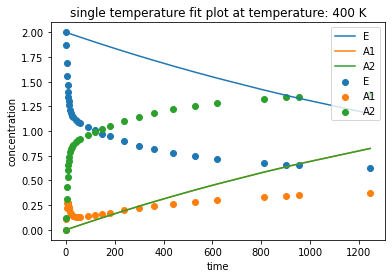

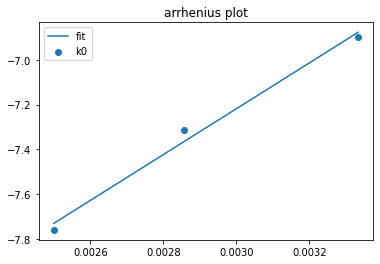

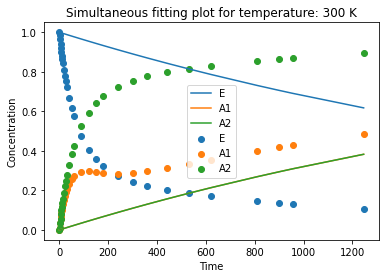

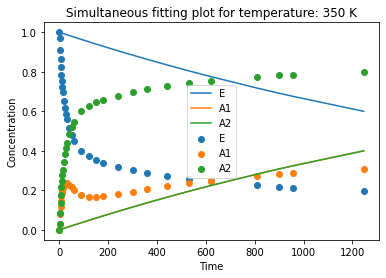

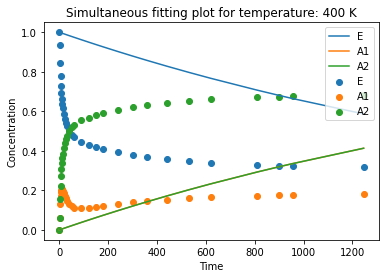

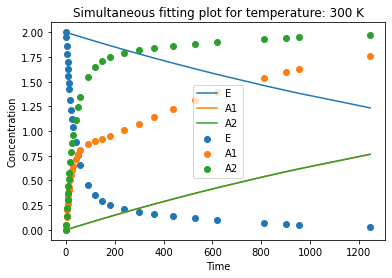

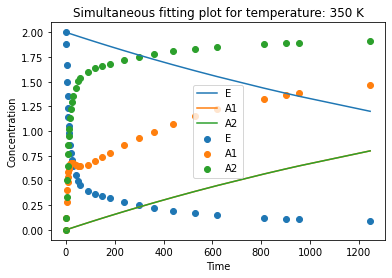

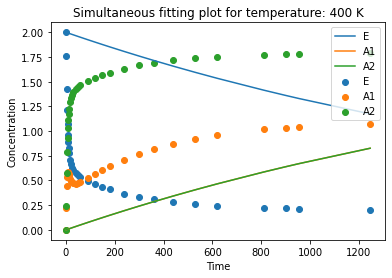

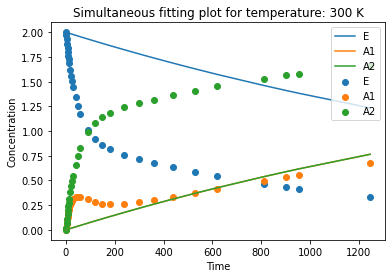

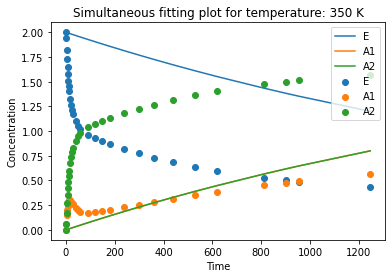

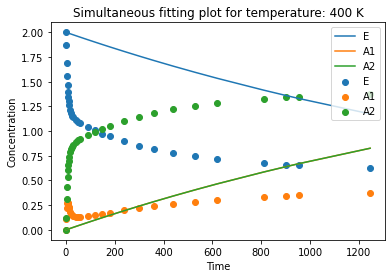

In [44]:
# Lets fit the data to that system, mind that the score could be terrible because the data and the system might not correspond
test_fit_1 = fit_data(data, test) #We make a fitting set with the fit_data class
test_fit_1.fit_full(0)#a full fit means we find all rate constants and then combine them into guesses for the kinetic parameters. We then also guess the kinetic parameter

  2% (24 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:34

score for temperature fit of 300 is: -15.671534498795005 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 1
    # variables        = 1
    chi-square         = 469.655408
    reduced chi-square = 469.655408
    Akaike info crit   = 8.15199925
    Bayesian info crit = 6.15199925
[[Variables]]
    k0:  0.00190257 +/- 465.043245 (24442925.31%) (init = 0.01)


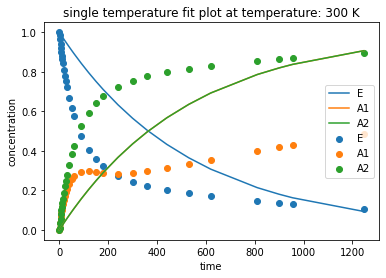

In [45]:
#now to exhibit different types of fitting
test_fit_1 = fit_data(data, test)#this is the function to fit a single system to a single dataset, first argumet is the dataset that is fit
test_fit_1.fit_one(0,0)#in this dataset 0 (first initial condition, first temperature), and the second argument is the system of ODE's, this is 0 since we only have one syste

  0% (5 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:23

score for temperature fit of 300 is: -15.671534498795005 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 1
    # variables        = 1
    chi-square         = 469.655408
    reduced chi-square = 469.655408
    Akaike info crit   = 8.15199925
    Bayesian info crit = 6.15199925
[[Variables]]
    k0:  0.00190257 +/- 465.043245 (24442925.31%) (init = 0.01)


  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:27

score for temperature fit of 350 is: -28.854111308348223 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 1
    # variables        = 1
    chi-square         = 1214.80908
    reduced chi-square = 1214.80908
    Akaike info crit   = 9.10234220
    Bayesian info crit = 7.10234220
[[Variables]]
    k0:  6.4471e-04 +/- 7917.38801 (1228054119.38%) (init = 0.01)


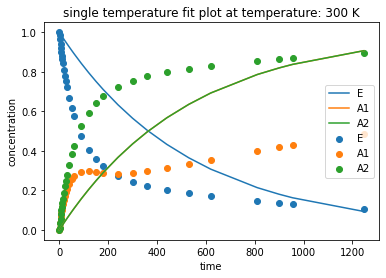

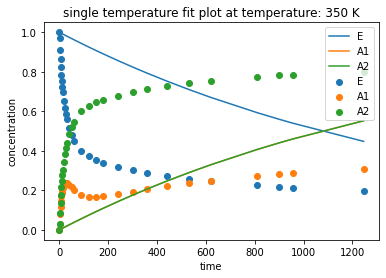

In [46]:
#fit many is for fittin many datasets with the same system at once, the first argument is now a list of all datasets you want to fit
test_fit_1.fit_many_entries([0,1],0) #try it out, there ar 4 datasets so [0:] also works for example

In [47]:
# Now for an exmple that takes multiple constants and systems of ODE's into account
ks_2 = 2 # Now we have 2 constants


reactions_2 = {1:["ks[0]*concs[0]"],# Which concentration is 0,1,etc. is defined by the order of the matrix below
               2:["ks[1]*concs[3]"]}# There are 2 reactions now, one is substrate depleteion, the second is catalyst death

matrix_2 = {"dEdt": {1:-1},
          "dA1dt": {1:1},
          "dA2dt": {1:1},
         "dprecatdt": {2:-1},
         "ddeadcatdt": {2:1}} #All the species, and the reactions they participate in

to_run_2 = [{1:1,2:1},{1:1}] # Now comes the part where we make 2 systems, one is with catalyst death , so it inludes reaction 1 and 2,
#the second is without catalyst death, so it only includes the first reactions, the reason this is a dictionary is shown in test_6 later

In [48]:
test_2 = ODE_systems(reactions_2,matrix_2,ks_2,to_run_2)# Make ODE systems out of it, if to_run is included it automatically
# Detects how many systems there are, and makes them all.

  0% (2 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:04

score for temperature fit of 300 is: -56.988313179260615 out of 30 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 2
    # variables        = 2
    chi-square         = 15133.9333
    reduced chi-square = 15133.9333
    Akaike info crit   = 21.8630951
    Bayesian info crit = 19.2493895
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  0.00100908 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 350 is: -92.53835125459634 out of 30 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 2
    # variables        = 2
    chi-square         = 30031.2951
    reduced chi-square = 30031.2951
    Akaike info crit   = 23.2336962
    Bayesian info crit = 20.6199906
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  6.6621e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  3% (33 of 1000) |                      | Elapsed Time: 0:00:03 ETA:   0:01:36

score for temperature fit of 400 is: -137.47062473015347 out of 30 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 2
    # variables        = 2
    chi-square         = 56092.8203
    reduced chi-square = 56092.8203
    Akaike info crit   = 24.4832318
    Bayesian info crit = 21.8695262
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  4.2627e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  2% (24 of 1000) |                      | Elapsed Time: 0:00:11 ETA:   1:43:10

full fit score is: -295.21474001194485 out of 126
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 4
    # variables        = 4
    chi-square         = 709687.429
    reduced chi-square = 709687.429
    Akaike info crit   = 56.3451422
    Bayesian info crit = 53.8903196
##  Warning: uncertainties could not be estimated:
    A2:  at initial value
    E2:  at initial value
    E2:  at boundary
[[Variables]]
    A1:  5.7794e-04 (init = 3.382009e-05)
    A2:  0.01000000 (init = 0.01)
    E1:  1000.77822 (init = 1000)
    E2:  1000.00000 (init = 1000)


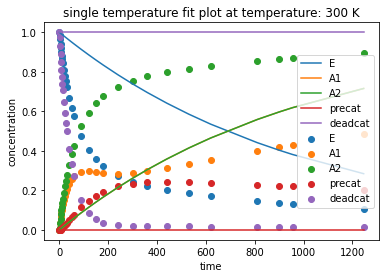

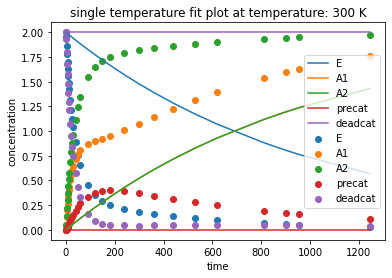

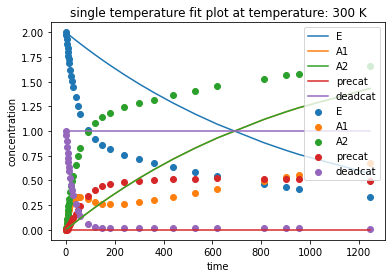

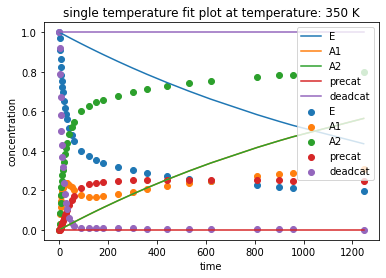

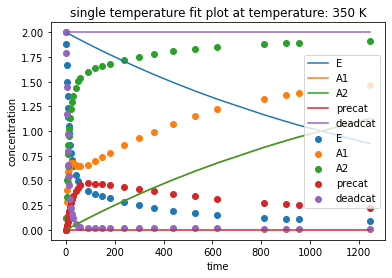

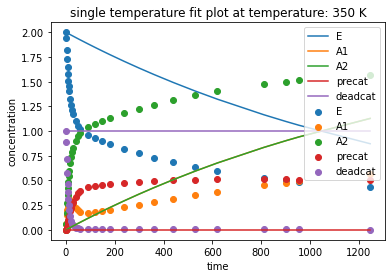

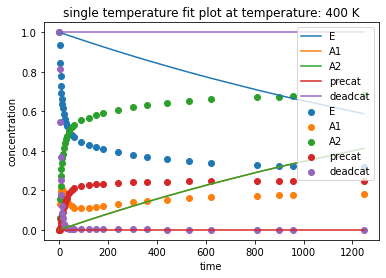

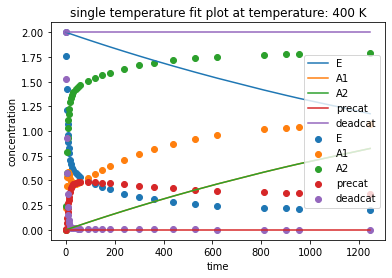

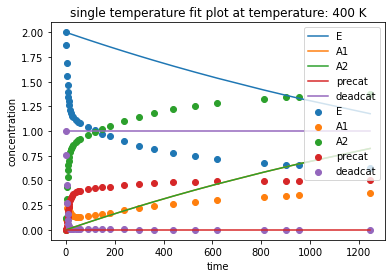

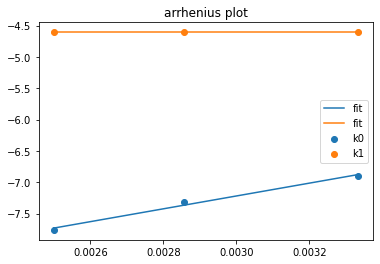

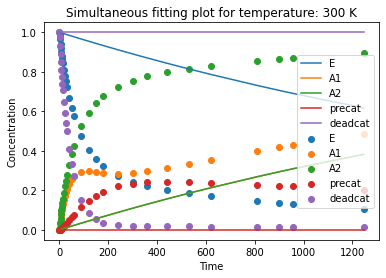

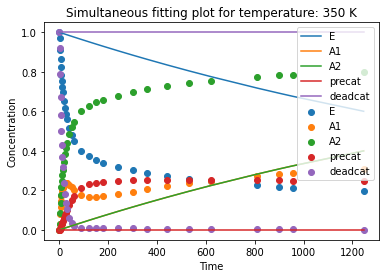

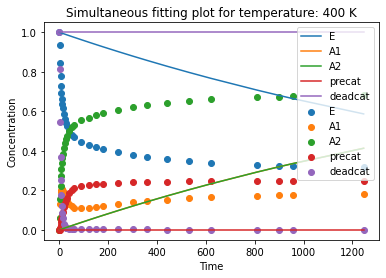

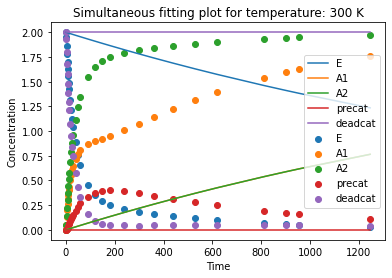

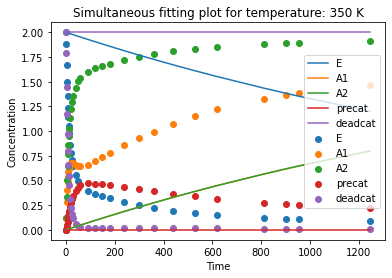

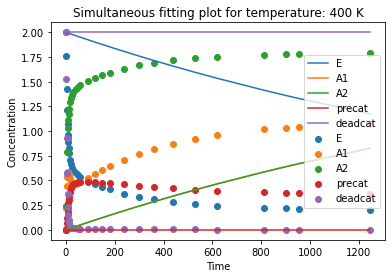

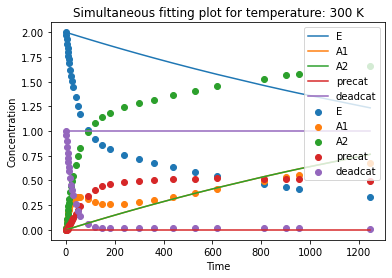

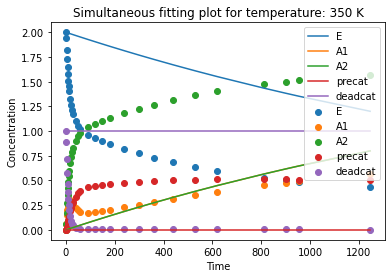

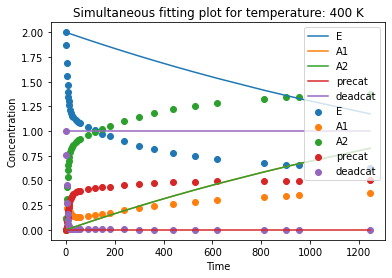

In [49]:
# Here we now see that the first system is with catalyst death, and the second system is without
# For the second system the unneeded second reaction constant is set to 0, and unneeded concentrations are automatically dropped.
test_fit_2 = fit_data(data, test_2)
test_fit_2.fit_full(0)

  3% (30 of 1000) |                      | Elapsed Time: 0:00:01 ETA:   0:00:34

score for temperature fit of 300 is: -15.671534498795005 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 2
    # variables        = 2
    chi-square         = 939.310815
    reduced chi-square = 939.310815
    Akaike info crit   = 16.3039985
    Bayesian info crit = 13.6902929
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  0.00190257 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


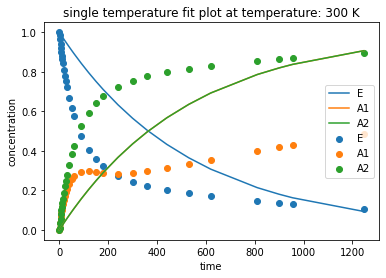

In [50]:
# Again some other fitting types
test_fit_2 = fit_data(data, test_2)
test_fit_2.fit_one(0,1) # data number 0 and system number 1

  0% (5 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:21

score for temperature fit of 350 is: -28.85411130834885 out of 10 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 2
    # variables        = 2
    chi-square         = 3019.28393
    reduced chi-square = 3019.28393
    Akaike info crit   = 18.6392556
    Bayesian info crit = 16.0255499
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  6.4471e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  2% (28 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26

score for temperature fit of 350 is: -28.854111308348585 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 2
    # variables        = 2
    chi-square         = 2429.61815
    reduced chi-square = 2429.61815
    Akaike info crit   = 18.2046844
    Bayesian info crit = 15.5909788
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  6.4471e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


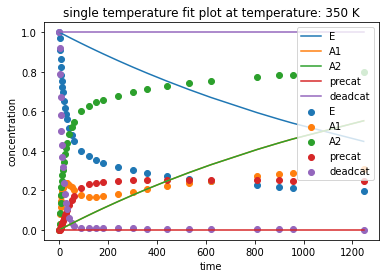

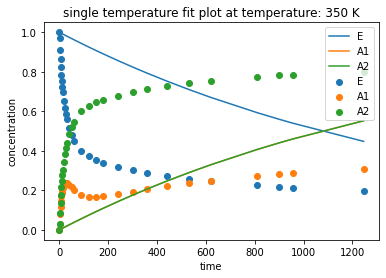

In [51]:
# and a new type, now we fit the data with both the first and second system, the difference can be seen in the resulting graphs
test_fit_2.fit_many_systems(1,[0,1])

  0% (3 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:38

score for temperature fit of 300 is: -15.671534497515104 out of 10 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 2
    # variables        = 2
    chi-square         = 1318.05537
    reduced chi-square = 1318.05537
    Akaike info crit   = 16.9815311
    Bayesian info crit = 14.3678254
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  0.00190251 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  0% (3 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:38

score for temperature fit of 300 is: -15.671534498795005 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 2
    # variables        = 2
    chi-square         = 939.310815
    reduced chi-square = 939.310815
    Akaike info crit   = 16.3039985
    Bayesian info crit = 13.6902929
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  0.00190257 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  0% (4 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:28

score for temperature fit of 350 is: -28.85411130834885 out of 10 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 2
    # variables        = 2
    chi-square         = 3019.28393
    reduced chi-square = 3019.28393
    Akaike info crit   = 18.6392556
    Bayesian info crit = 16.0255499
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  6.4471e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


  2% (28 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:28

score for temperature fit of 350 is: -28.854111308348585 out of 6 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 2
    # variables        = 2
    chi-square         = 2429.61815
    reduced chi-square = 2429.61815
    Akaike info crit   = 18.2046844
    Bayesian info crit = 15.5909788
##  Warning: uncertainties could not be estimated:
    k1:  at initial value
[[Variables]]
    k0:  6.4471e-04 (init = 0.01)
    k1:  0.01000000 (init = 0.01)


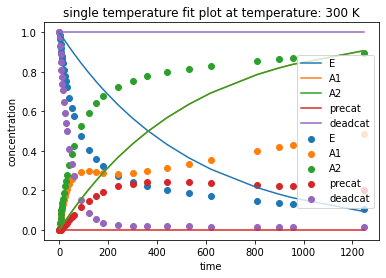

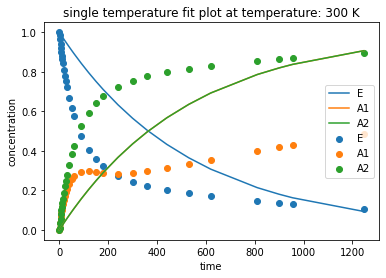

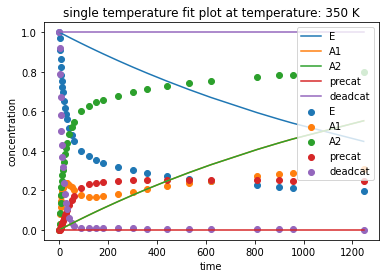

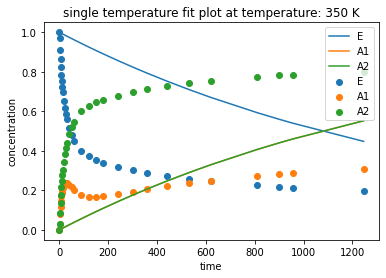

In [52]:
# Now multiple datasets and multiple systems
test_fit_2.fit_many([0,1],[0,1])

In [53]:
#now for a highly complex system example
ks_6 = 6

reactions_6 = {1: ["ks[0]*concs[0]*concs[4]","ks[0]*concs[0]"], #note that we now define that reaction 1 can have 2 different options
               2: ["ks[1]*concs[0]*concs[1]"],
               3: ["ks[2]*concs[2]*concs[3]"],
               4 : ["ks[3]*concs[3]*concs[4]"],
               5: ["ks[4]*concs[5]*0.04"], #hydrogen concentration, constants can easily be added
               6: ["ks[5]*concs[4]"]}

matrix_6 = {"dEdt": {1:-1, 2:-1, 3:1}, #example of how a more complex matrix looks
          "dA1dt": {1:1, 2:-1, 3:1, 4:2},
          "dA2dt": {1:1, 2:1, 3:-1},
            "dtEdt": {2:1, 3:-1, 4:-1},
         "dprecatdt": {1:-1, 4:-1, 5:1, 6:-1},
         "dcatdt": {1:1, 4:1, 5:-1},
           "dcatdeaddt": {6:1},}

to_run_6 = [{1:1,2:1,3:1,4:1,5:1,6:1},{1:1,2:1,3:1,5:1,6:1},{1:2,2:1,3:1,4:1,5:1,6:1}] #the last entry explains why this is a dictionary
#if a researcher wants to simultaneously runs systems with different reaction options they can be selected per system in the to_run parameter dictionaries
# Reaction one has 2 options, so the 2 in the last dictionary denotes that

In [54]:
test_6 = ODE_systems(reactions_6,matrix_6,ks_6,to_run = to_run_6)
test_fit_6 = fit_data(data, test_6)

 42% (421 of 1000) |########             | Elapsed Time: 0:00:41 ETA:   0:01:08

score for temperature fit of 300 is: 13.681636392956152 out of 14 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 417
    # data points      = 6
    # variables        = 6
    chi-square         = 0.60813232
    reduced chi-square = 0.60813232
    Akaike info crit   = -1.73473357
    Bayesian info crit = -2.98417676
##  Warning: uncertainties could not be estimated:
    k3:  at initial value
[[Variables]]
    k0:  0.01299380 (init = 0.01)
    k1:  0.01031102 (init = 0.01)
    k2:  0.00528784 (init = 0.01)
    k3:  0.01000000 (init = 0.01)
    k4:  0.02614570 (init = 0.01)
    k5:  0.00975305 (init = 0.01)


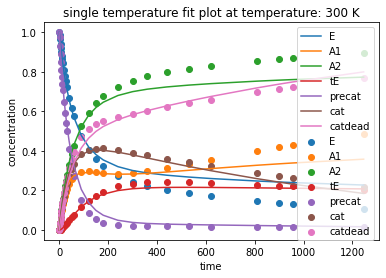

In [55]:
# here it will be apparent that single kinetic profiles are not enough for getting good results with complex data
test_fit_6.fit_one(0,1,iterations = 1000) #you can set the amount of iterations

  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 300 is: 41.99999999939027 out of 42 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 574
    # data points      = 6
    # variables        = 6
    chi-square         = 2.2306e-18
    reduced chi-square = 2.2306e-18
    Akaike info crit   = -242.616040
    Bayesian info crit = -243.865483
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:  0.01200004 (init = 0.01)
    k1:  0.01499987 (init = 0.01)
    k2:  0.00399994 (init = 0.01)
    k3:  0.03999945 (init = 0.01)
    k4:  0.03000017 (init = 0.01)
    k5:  0.01199994 (init = 0.01)


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 350 is: 41.99166164538712 out of 42 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 4.1717e-04
    reduced chi-square = 4.1717e-04
    Akaike info crit   = -45.4426724
    Bayesian info crit = -46.6921156
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:  0.03264221 (init = 0.01)
    k1:  0.03298010 (init = 0.01)
    k2:  0.01013844 (init = 0.01)
    k3:  0.07192746 (init = 0.01)
    k4:  0.06153527 (init = 0.01)
    k5:  0.04687607 (init = 0.01)


100% (1000 of 1000) |####################| Elapsed Time: 0:05:37 ETA:  00:00:00

score for temperature fit of 400 is: 41.06090497513729 out of 42 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 5.29139679
    reduced chi-square = 5.29139679
    Akaike info crit   = 11.2459367
    Bayesian info crit = 9.99649353
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:  0.07134583 (init = 0.01)
    k1:  0.05462150 (init = 0.01)
    k2:  0.02273897 (init = 0.01)
    k3:  5.1265e-05 (init = 0.01)
    k4:  0.10338034 (init = 0.01)
    k5:  0.11535069 (init = 0.01)


 53% (532 of 1000) |###########          | Elapsed Time: 0:07:26 ETA:   0:31:49

full fit score is: 119.93337734688268 out of 126
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 530
    # data points      = 12
    # variables        = 12
    chi-square         = 441.646925
    reduced chi-square = 441.646925
    Akaike info crit   = 67.2672492
    Bayesian info crit = 73.0861290
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A1:  14.8128855 +/- 1.1053e+09 (7461700569.28%) (init = 14.81717)
    A2:  2.54466944 +/- 9.2149e+08 (36212657129.11%) (init = 2.725121)
    A3:  4.00230652 +/- 1.3150e+09 (32855554795.60%) (init = 4.006943)
    A4:  1733.06515 +/- 2.0804e+13 (1200442652059.06%) (init = 1e-05)
    A5:  3.82861856 +/- 1.0496e+10 (274148388162.15%) (init = 4.262531)
    A6:  106.377911 +/- 1.5743e+10 (14799526739.82%) (init = 107.2771)
    E1:  17658.0377 +/-        nan (nan%) (init = 17768)
    E2:  13258.6116 +/-        nan (nan%) (init = 12940.46)
    E3:  16930.2043 +/- 1.4810e+13 (87477611079

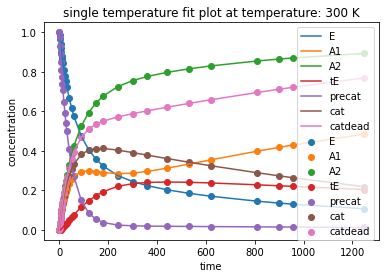

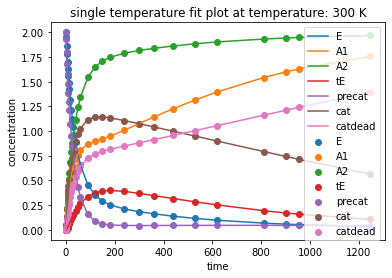

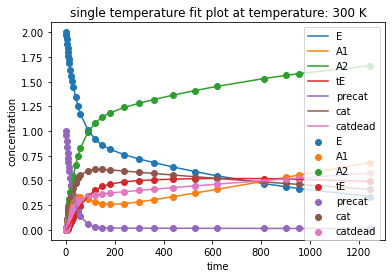

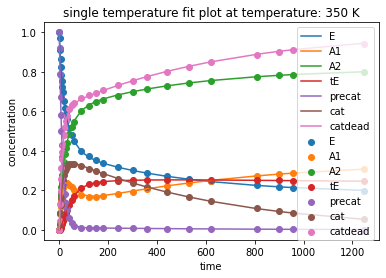

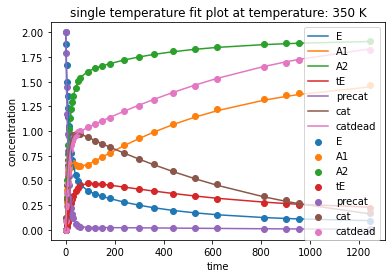

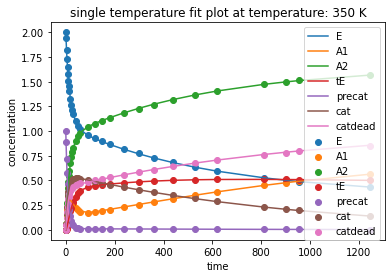

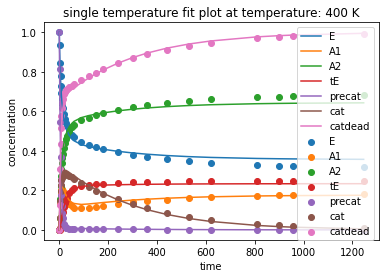

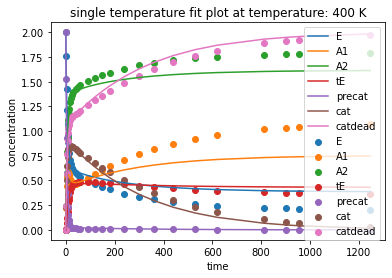

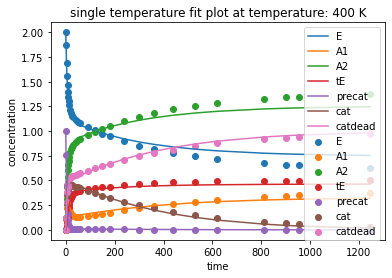

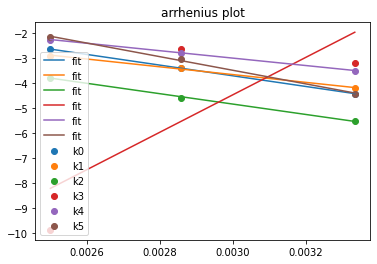

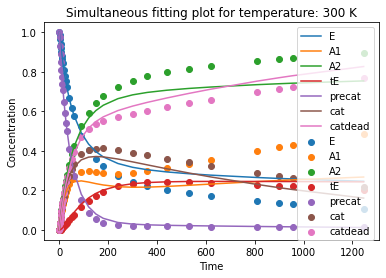

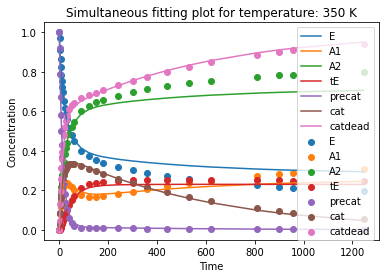

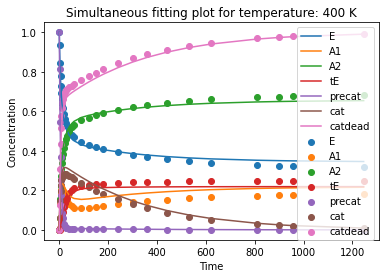

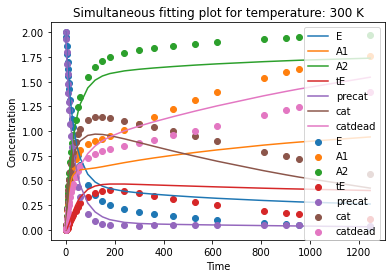

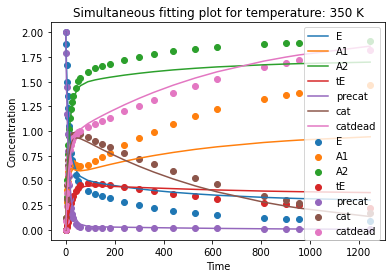

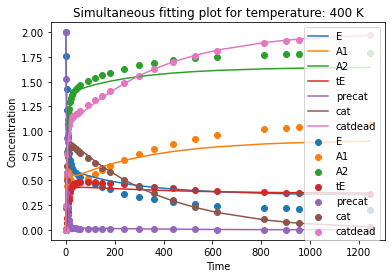

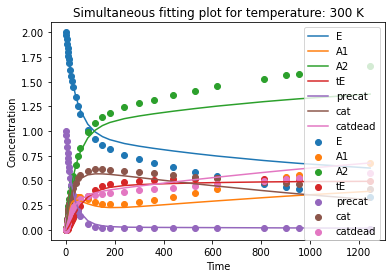

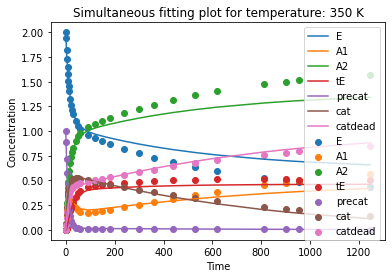

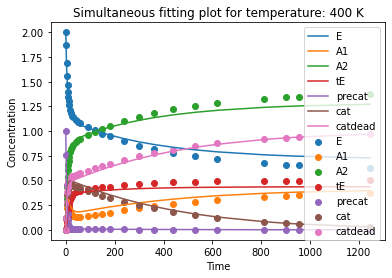

In [56]:
#this one might take long, but show the power of the algoritm, a full fitting of the right data with the right system, if you used the complex data
test_fit_6.fit_full(0, iterations = 1000, iterations_full = 1000)

In [62]:
#here are some cells to test your own
def custom(x, init, rate_const):
    CA,CB,CC,CD,CE,CF,CG,CH = init
    k1, k2= rate_const[0],rate_const[1]
    dAdt = -k1*CA
    dBdt = k1*CA-k2*CB*CC
    dCdt = k1*CA-k2*CB*CC
    dDdt = k2*CB*CC
    return dAdt, dBdt, dCdt, dDdt, 0, 0, 0, 0

In [63]:
ks = 2
reactions = {1 : ["ks[0]*concs[0]"],
            2 : ["ks[1]*concs[1]*concs[2]", 'ks[1]*concs[1]*concs[2]*concs[0]']}

matrix = {"dAdt": {1:-1},
         "dBdt": {1:1, 2:-1},
         "dCdt": {1:1, 2:-1},
         "dDdt": {2:1}}
to_run = [{1:1, 2:1}, {1:1,2:2}]

In [64]:
data = make_data(custom,timespan ,[300,400],[[1,0,0,0,1,0,0,0],[2,0,0,0,2,0,0,0]],[0.04,0.005],var_noise = 0.05, stat_noise = 0.01,kin_params = [15000,8000])

In [65]:
test_custom = ODE_systems(reactions,matrix,ks,to_run)

  0% (5 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:22

score for temperature fit of 300 is: 12.583112635828309 out of 16 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 246
    # data points      = 2
    # variables        = 2
    chi-square         = 23.3502385
    reduced chi-square = 23.3502385
    Akaike info crit   = 8.91492004
    Bayesian info crit = 6.30121440
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:  0.04149962 +/-        nan (nan%) (init = 0.01)
    k1:  0.00488121 +/-        nan (nan%) (init = 0.01)


  0% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

score for temperature fit of 400 is: 14.652809778681231 out of 16 
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 2
    # variables        = 2
    chi-square         = 3.62984298
    reduced chi-square = 3.62984298
    Akaike info crit   = 5.19208442
    Bayesian info crit = 2.57837878
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k0:  0.17774727 (init = 0.01)
    k1:  0.01137805 (init = 0.01)


100% (1000 of 1000) |####################| Elapsed Time: 0:02:44 ETA:  00:00:00

full fit score is: 27.239542825744902 out of 32
 
 fit results:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 4
    # variables        = 4
    chi-square         = 90.6478100
    reduced chi-square = 90.6478100
    Akaike info crit   = 20.4827497
    Bayesian info crit = 18.0279271
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A1:  14.0994704 (init = 13.96623)
    A2:  0.14610483 (init = 0.1441083)
    E1:  14494.5078 (init = 14513.04)
    E2:  8490.14624 (init = 8443.296)


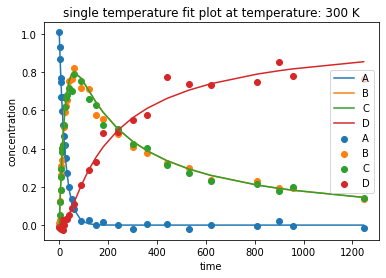

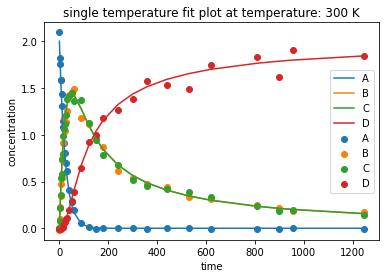

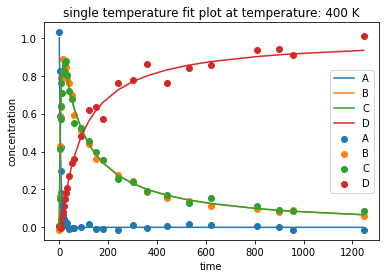

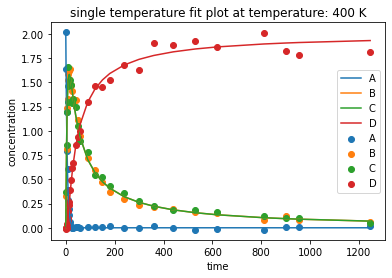

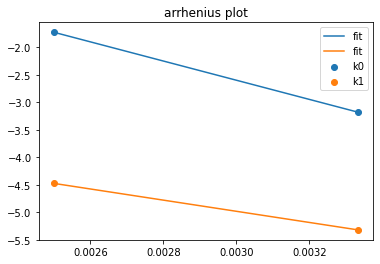

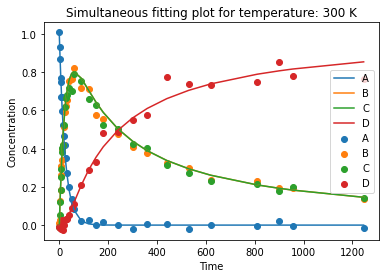

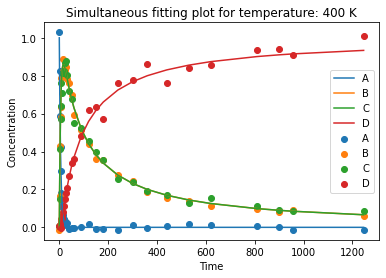

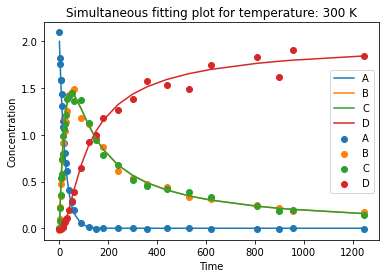

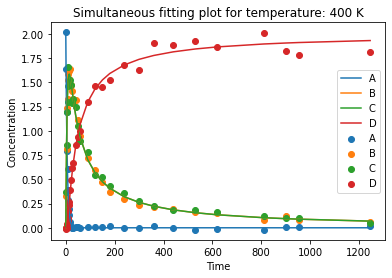

In [66]:
test_fit = fit_data(data, test_custom) #we make a fitting set with the fit_data class, ODE systems need to be converted to the right reaction matrix with the get_matrices() function
test_fit.fit_full(0)